# 모든 장르 간 편향성 측정해 보기

In [26]:
import konlpy
import gensim
import sklearn
import seaborn as sns

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(sns.__version__)

0.5.2
4.1.2
1.0
0.11.2


## STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기


In [ ]:
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)   # 한국어 문장을 형태소 단위로 나누고, 형태소에 품사(Part-Of-Speech,POS) 태그를 부착함
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)   

In [28]:
len(tokenized)

71156

In [29]:
tokenized[0]

['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분']

In [38]:
type(tokenized)

list

In [39]:
type(tokenized[0])

list

tokenized는 리스트의 리스트 타입을 가짐

## STEP 2. 추출된 결과로 embedding model 만들기

In [30]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)

In [31]:
model.wv.most_similar(positive=['영화'])

[('작품', 0.8912518620491028),
 ('다큐멘터리', 0.8673540949821472),
 ('드라마', 0.8247410655021667),
 ('영화로', 0.8169446587562561),
 ('에마데딘', 0.7903977036476135),
 ('코미디', 0.788392961025238),
 ('형식', 0.7816569805145264),
 ('시대극', 0.7720797657966614),
 ('주제', 0.7711399793624878),
 ('개연', 0.7648971080780029)]

In [32]:
model.wv.most_similar(positive=['사랑'])

[('행복', 0.7128023505210876),
 ('아르튬', 0.6978785991668701),
 ('만남', 0.6771820187568665),
 ('애정', 0.676022469997406),
 ('연애', 0.6728733777999878),
 ('운명', 0.6723964810371399),
 ('진심', 0.6676895022392273),
 ('첫사랑', 0.6636291742324829),
 ('이별', 0.6618033647537231),
 ('상처', 0.6615509986877441)]

In [33]:
model.wv.most_similar(positive=['연극'])

[('영화감독', 0.8903211951255798),
 ('영감', 0.8891213536262512),
 ('시나리오', 0.8776816129684448),
 ('배우', 0.8772310614585876),
 ('캐스팅', 0.8771041631698608),
 ('뮤지션', 0.8770707249641418),
 ('오페라', 0.8738270401954651),
 ('데뷔', 0.8736843466758728),
 ('아역', 0.8701114654541016),
 ('연기자', 0.8683286309242249)]

## STEP 3. target, attribute 단어 셋 만들기

In [18]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

# 파일을 읽어서, konlpy의 Okt를 이용해, 문장을 형태소 단위로 나누고, 형태소에 품사 태깅 후, 명사만 추출하여, 공백으로 조인한 문장을 반환
def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True)  # 한국어 문장을 형태소 단위로 나누고, 형태소에 품사(Part-Of-Speech,POS) 태그를 부착함
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

##### target

In [19]:
# 확인
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [37]:
# 확인
art[:10]

'사운드 엔지니어 상'

In [36]:
# 확인
gen[:50]

'유사 연령 성별 빈부 차이 정치 입장 불문 국민 통합 온 애국심 성역 일침 다큐멘터리 재작'

In [135]:
vectorizer_target = TfidfVectorizer()
X_target = vectorizer_target.fit_transform([art, gen])

In [139]:
m1 = X_target[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X_target[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer_target.get_feature_names_out()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer_target.get_feature_names_out()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [140]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer_target.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer_target.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

##### attributes

In [40]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [43]:
len(genre_txt)

21

In [44]:
len(genre_name)

21

In [41]:
# 모든 장르를 명사만 추출해서, 공백으로 조인한 문장 형태로 변환하고, genre 리스트에 추가
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


#### TF-IDF로 벡터화

In [42]:
# 모든 장르로 tf-idf 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)  # tf-idf vectorizer의 fit_transform 리턴은 희소행렬

print(X.shape)

(21, 42191)


In [51]:
print(type(X))
print(type(X[0]))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


In [49]:
print(X[0])

  (0, 13952)	0.0033499152670364227
  (0, 2039)	0.002285577535002845
  (0, 36242)	0.0027154578798064487
  (0, 24831)	0.004586815128045722
  (0, 37721)	0.0021681209719700955
  (0, 7717)	0.00289571176127901
  (0, 7669)	0.0020600714080574456
  (0, 39780)	0.0020600714080574456
  (0, 33059)	0.004586815128045722
  (0, 22451)	0.004039478220209368
  (0, 12262)	0.0025564626882533786
  (0, 30804)	0.00289571176127901
  (0, 2066)	0.0033499152670364227
  (0, 21022)	0.0033499152670364227
  (0, 22525)	0.003103799596089732
  (0, 33036)	0.00289571176127901
  (0, 9187)	0.0054309157596128975
  (0, 17581)	0.003103799596089732
  (0, 33873)	0.0020600714080574456
  (0, 41140)	0.0024142366429167855
  (0, 3176)	0.0016979421447241006
  (0, 1538)	0.001960033137159373
  (0, 11684)	0.004039478220209368
  (0, 34375)	0.00457115507000569
  (0, 7162)	0.0024142366429167855
  :	:
  (0, 18939)	0.01458705657720368
  (0, 24104)	0.003103799596089732
  (0, 33904)	0.008476177375938119
  (0, 1789)	0.0032415681282674845
  (0, 26

In [48]:
print(X[0].tocoo())

  (0, 13952)	0.0033499152670364227
  (0, 2039)	0.002285577535002845
  (0, 36242)	0.0027154578798064487
  (0, 24831)	0.004586815128045722
  (0, 37721)	0.0021681209719700955
  (0, 7717)	0.00289571176127901
  (0, 7669)	0.0020600714080574456
  (0, 39780)	0.0020600714080574456
  (0, 33059)	0.004586815128045722
  (0, 22451)	0.004039478220209368
  (0, 12262)	0.0025564626882533786
  (0, 30804)	0.00289571176127901
  (0, 2066)	0.0033499152670364227
  (0, 21022)	0.0033499152670364227
  (0, 22525)	0.003103799596089732
  (0, 33036)	0.00289571176127901
  (0, 9187)	0.0054309157596128975
  (0, 17581)	0.003103799596089732
  (0, 33873)	0.0020600714080574456
  (0, 41140)	0.0024142366429167855
  (0, 3176)	0.0016979421447241006
  (0, 1538)	0.001960033137159373
  (0, 11684)	0.004039478220209368
  (0, 34375)	0.00457115507000569
  (0, 7162)	0.0024142366429167855
  :	:
  (0, 18939)	0.01458705657720368
  (0, 24104)	0.003103799596089732
  (0, 33904)	0.008476177375938119
  (0, 1789)	0.0032415681282674845
  (0, 26

In [52]:
print(type(X[0].tocoo()))

<class 'scipy.sparse.coo.coo_matrix'>


In [56]:
print(X[0].row)

AttributeError: row not found

In [57]:
# 1행 42191열로 구성된 행렬; 데이터가 있는 행 -> 1행[0인덱스 행]; 데이터가 있는 열의 인덱스들; 데이터
print(X[0].tocoo().row)
print(X[0].tocoo().col)
print(X[0].tocoo().data)

[0 0 0 ... 0 0 0]
[13952  2039 36242 ... 39665 31911 20740]
[0.00334992 0.00228558 0.00271546 ... 0.0061912  0.00412014 0.07154464]


`tocoo()`는 희소행렬을 coo 타입으로 변환, print 결과는 같지만, `비어 있지 않은 원소의 좌표 값` 정보가 추가됨.

각 장르를 대표하는 단어 추출

In [58]:
# 가능하지만
X.tocoo()

<21x42191 sparse matrix of type '<class 'numpy.float64'>'
	with 149613 stored elements in COOrdinate format>

In [91]:
# 각 장르 문서 마다 작업; 각 장르 문서를 coo 타입으로 변경, 문서마다 개별 분석을 하기 위해, 문서마다 처리해줌
# X[i]는 1행 42191열의 형태를 가짐
m = [X[i].tocoo() for i in range(X.shape[0])]

# 각 장르 문서마다 작엄; 각 문서에서 데이터가 있는 열의 인덱스와 데이터를 저장;
# 데이터가 있는 부분만 저장.
# mm -> 개별 장르문서의 coo 타입의 matrix, [열인덱스, 데이터] 형식으로 저장.
w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

# 문서마다 작업; tf-idf 값 기준으로 내림차순 정렬
for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)

# 상위 15개 추출하는 작업
attributes = []
for i in range(len(w)):    # 문서마다 작업
    print(genre_name[i], end=': ')   # 문서 장르이름 출력
    attr = []    # 현재 문서의 상위 단어들 저장용 리스트
    j = 0   # 상위단어 인덱스
    while (len(attr) < 30):
        word = vectorizer.get_feature_names_out()[w[i][j][0]]  # w[i][j]는 [단어 인덱스, TF-IDF 값] 형태의 리스트이니까
        if word in model.wv:   
            attr.append(word)
            print(word, end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 외계, 존재, 세상, 발견, 행성, 정체, 친구, 비밀, 사실, 기억, 전쟁, 사건, 시간, 공격, 영화, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 할머니, 씨제이, 동구, 사랑, 아이, 사람, 학교, 세상, 소년, 슈이트, 이야기, 가장, 어머니, 마갈, 소녀, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 카르피, 비바, 왕자, 콘서트, 백작부인, 반니, 아리아, 미노, 차이코프스키, 라다, 무대, 도시, 공작, 리코, 시작, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 영화, 사실, 소녀, 하나, 살인, 이야기, 비밀, 아이, 정체, 저주, 살해, 영화제, 여자, 모든, 의문, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 여자, 대한, 독립, 친구, 작품, 엄마, 통해, 아시아나, 다른, 우리, 연출, 소녀, 모습, 아이, 시간, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 통해, 그녀, 여성, 가족, 한국, 작품, 환경, 사회, 모습, 아이, 마을, 노동자, 세상, 가장, 기록, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 가족, 단편, 서울, 대한, 아들, 마음, 아이, 남편, 서로, 시간, 소녀, 세상, 감독, 다른, 모든, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 관계, 부부,

임베딩 모델에 있는 단어 중에서 상위 단어를 추출하고 있음. => 임베딩 모델 학습 데이터는 synopsis.txt 뿐이였음. -> 생각해볼 부분(전체 데이터로 만든다면??)

In [92]:
attributes

[['위해',
  '자신',
  '지구',
  '시작',
  '사람',
  '인류',
  '인간',
  '미래',
  '우주',
  '그녀',
  '로봇',
  '세계',
  '모든',
  '박사',
  '우주선',
  '외계',
  '존재',
  '세상',
  '발견',
  '행성',
  '정체',
  '친구',
  '비밀',
  '사실',
  '기억',
  '전쟁',
  '사건',
  '시간',
  '공격',
  '영화'],
 ['엄마',
  '아빠',
  '가족',
  '영화제',
  '자신',
  '위해',
  '친구',
  '아주르',
  '아버지',
  '시작',
  '그녀',
  '아들',
  '마을',
  '국제',
  '낙타',
  '할머니',
  '씨제이',
  '동구',
  '사랑',
  '아이',
  '사람',
  '학교',
  '세상',
  '소년',
  '슈이트',
  '이야기',
  '가장',
  '어머니',
  '마갈',
  '소녀'],
 ['오페라',
  '사랑',
  '토스카',
  '실황',
  '올레',
  '자신',
  '카바',
  '그녀',
  '공연',
  '오텔로',
  '리골레토',
  '백작',
  '프레',
  '베르디',
  '위해',
  '카르피',
  '비바',
  '왕자',
  '콘서트',
  '백작부인',
  '반니',
  '아리아',
  '미노',
  '차이코프스키',
  '라다',
  '무대',
  '도시',
  '공작',
  '리코',
  '시작'],
 ['시작',
  '위해',
  '사람',
  '자신',
  '친구',
  '그녀',
  '사건',
  '공포',
  '발견',
  '죽음',
  '마을',
  '가족',
  '악령',
  '남자',
  '좀비',
  '영화',
  '사실',
  '소녀',
  '하나',
  '살인',
  '이야기',
  '비밀',
  '아이',
  '정체',
  '저주',
  '살해',
  '영화제',
  '여자',
  '모든',
  '의문'],
 ['영화제',
 

중복 단어 시각화

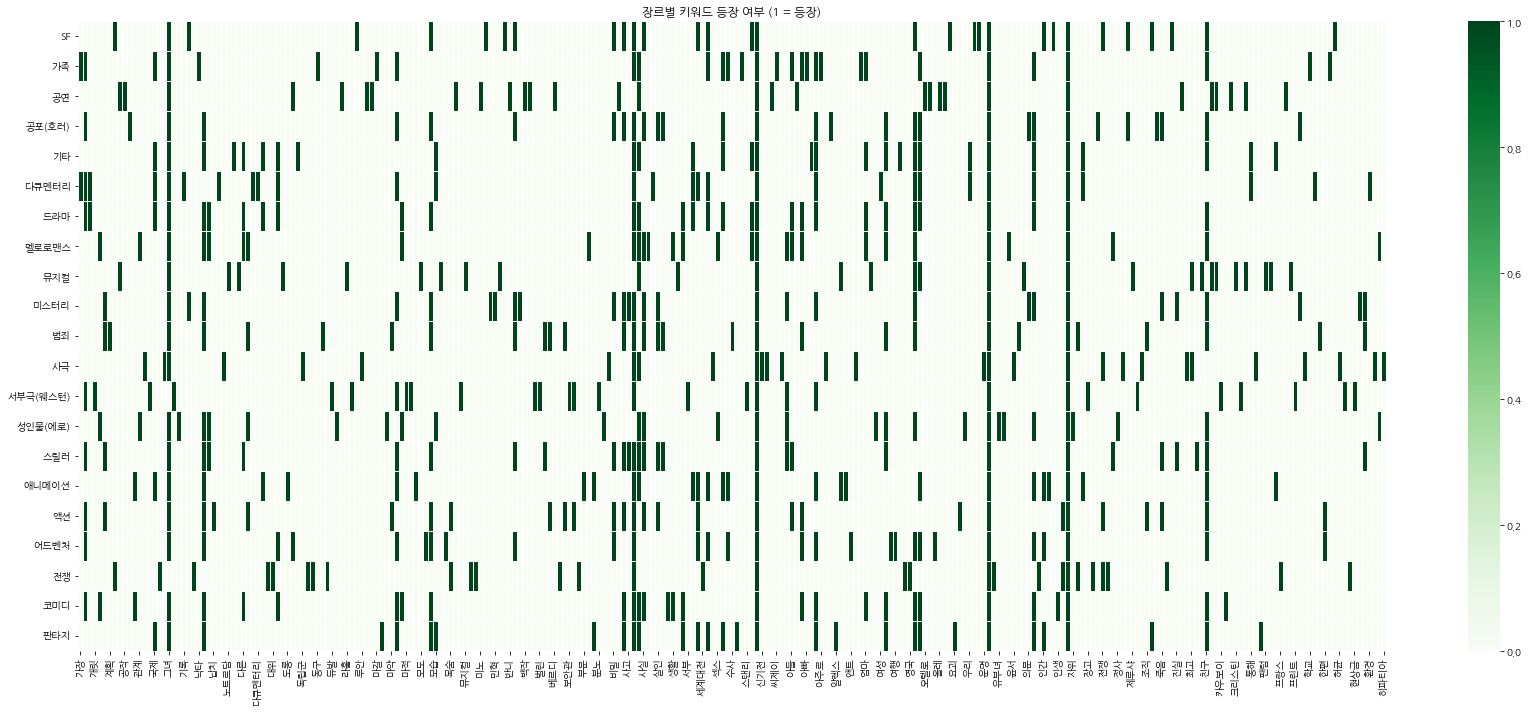

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'NanumGothic'

# 입력 데이터 (genre_name, data는 이미 정의됨)
all_keywords = sorted(set([word for genre_words in attributes for word in genre_words]))

# 0/1 매트릭스 (장르 x 단어)
df = pd.DataFrame(0, index=genre_name, columns=all_keywords)

for i, genre_words in enumerate(attributes):
    for word in genre_words:
        df.loc[genre_name[i], word] = 1

# 히트맵 시각화
plt.figure(figsize=(24, 10))
sns.heatmap(df, cmap='Greens', cbar=True, linewidths=0.5)
plt.title("장르별 키워드 등장 여부 (1 = 등장)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


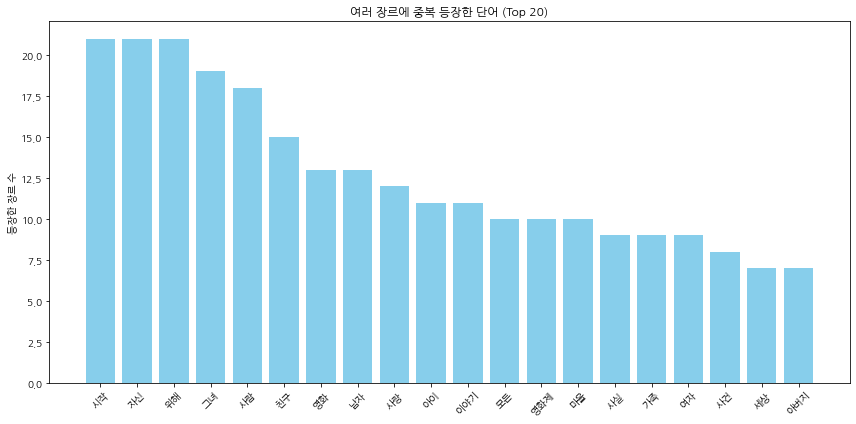

In [94]:
from collections import Counter

# 단어별 장르 등장 수 카운트
counter = Counter()
for genre_words in attributes:
    counter.update(set(genre_words))  # 중복 제거 후 카운트

# 상위 공통 단어 20개만 시각화
common = counter.most_common(20)

# Bar plot
words, counts = zip(*common)
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue')
plt.xticks(rotation=45)
plt.title("여러 장르에 중복 등장한 단어 (Top 20)")
plt.ylabel("등장한 장르 수")
plt.tight_layout()
plt.show()


기본적으로 상위 15개 단어만 확인했을때는 중복되는 단어가 많이 보임.   
'자신' 단어는 모든 장르에 다 포함되어 있다.  
이렇게 중복되는 단어는 개념축을 잘 나타낸다고 볼 수 없다.

In [105]:
# 6 장르 이상 등장한 단어만 추출
common_words_dup = [word for word, count in counter.items() if count >= 6]

# 결과 출력
common_words_dup
    

['시작',
 '친구',
 '모든',
 '세상',
 '영화',
 '사람',
 '사건',
 '사실',
 '발견',
 '세계',
 '비밀',
 '자신',
 '위해',
 '그녀',
 '국제',
 '소녀',
 '영화제',
 '아이',
 '사랑',
 '아버지',
 '가족',
 '마을',
 '이야기',
 '여자',
 '남자']

In [106]:
[word for word, count in counter.items() if count == 5]

['엄마', '아들', '살인', '대한', '다른', '아내']

In [119]:
df[df.loc[:,'살인'] ==1].index

Index(['공포(호러)', '미스터리', '범죄', '스릴러', '액션'], dtype='object')

위의 '살인'같은 단어는 장르를 대표하는 단어로 생각할 수 있다.  

6장르 이상에서 중복되는 단어를 제외시킨다

In [108]:
attributes_filtered = []  # 공통 단어 제외한 최종 결과 저장

for i in range(len(w)):  # 문서마다 작업
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while len(attr) < 15 and j < len(w[i]):
        word = vectorizer.get_feature_names_out()[w[i][j][0]]
        if (
            word in model.wv and        # Word2Vec에 존재하고
            word not in common_words_dup  # 공통 단어에 포함되지 않은 경우만
        ):
            attr.append(word)
            print(word, end=', ')
        j += 1
    attributes_filtered.append(attr)
    print()


SF: 지구, 인류, 인간, 미래, 우주, 로봇, 박사, 우주선, 외계, 존재, 행성, 정체, 기억, 전쟁, 시간, 
가족: 엄마, 아빠, 아주르, 아들, 낙타, 할머니, 씨제이, 동구, 학교, 소년, 슈이트, 가장, 어머니, 마갈, 미아, 
공연: 오페라, 토스카, 실황, 올레, 카바, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 카르피, 비바, 왕자, 콘서트, 
공포(호러): 공포, 죽음, 악령, 좀비, 하나, 살인, 정체, 저주, 살해, 의문, 점점, 사고, 명의, 시간, 다시, 
기타: 서울, 단편, 뉴미디어, 페스티벌, 대한, 독립, 작품, 엄마, 통해, 아시아나, 다른, 우리, 연출, 모습, 시간, 
다큐멘터리: 다큐, 다큐멘터리, 대한, 감독, 서울, 우리, 통해, 여성, 한국, 작품, 환경, 사회, 모습, 노동자, 가장, 
드라마: 엄마, 단편, 서울, 대한, 아들, 마음, 남편, 서로, 시간, 감독, 다른, 다시, 관계, 생각, 아내, 
멜로로맨스: 남편, 섹스, 마음, 결혼, 서로, 아내, 관계, 부부, 엄마, 점점, 다시, 회사, 시간, 사이, 생활, 
뮤지컬: 뮤지컬, 에스메랄다, 음악, 충무로, 모차르트, 토스카, 니웨, 카바, 바흐, 페뷔스, 프롤, 모도, 카르피, 제루샤, 샤오캉, 
미스터리: 사고, 진실, 죽음, 기억, 살인, 아내, 민혁, 의문, 미스터리, 형사, 하나, 경찰, 현우, 발생, 정체, 
범죄: 경찰, 범죄, 조직, 살인, 마약, 형사, 살해, 수사, 한길수, 범인, 계획, 은행, 작전, 동료, 다시, 
사극: 조선, 신기전, 아가멤논, 황제, 루안, 최고, 운명, 하선, 전쟁, 윤서, 트로이, 세자, 허균, 노준, 채선, 
서부극(웨스턴): 서부, 보안관, 벌린, 카우보이, 그레이프바인, 헨리, 개릿, 무법자, 프린트, 마적, 태구, 현상금, 분노, 버질, 랜던, 
성인물(에로): 남편, 마사지, 섹스, 관계, 정사, 유부녀, 마음, 에피소드, 그린, 아내, 다시, 자위, 회사, 불륜, 결혼, 
스릴러: 살인,

중복 단어를 제외시키는 방법에 대한 코드 개선이 필요하다. 

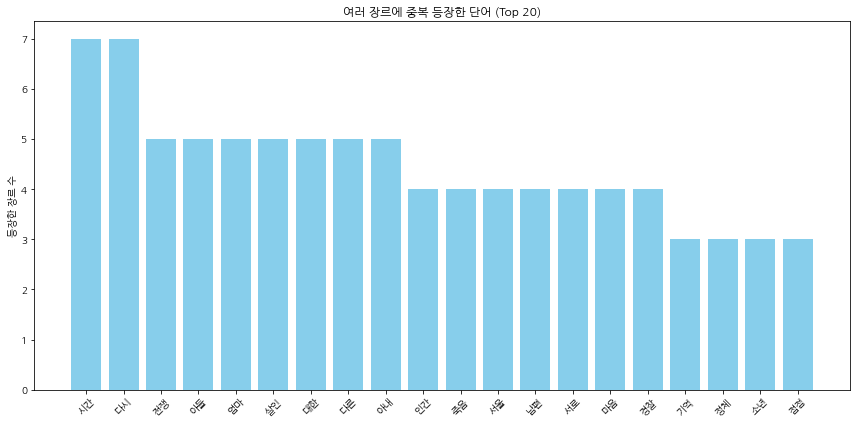

In [109]:
# 단어별 장르 등장 수 카운트
counter_filtered = Counter()
for genre_words in attributes_filtered:
    counter_filtered.update(set(genre_words))  # 중복 제거 후 카운트

# 상위 공통 단어 20개만 시각화
common_filtered = counter_filtered.most_common(20)

# Bar plot
words, counts = zip(*common_filtered)
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue')
plt.xticks(rotation=45)
plt.title("여러 장르에 중복 등장한 단어 (Top 20)")
plt.ylabel("등장한 장르 수")
plt.tight_layout()
plt.show()

In [125]:
# 입력 데이터 (genre_name, data는 이미 정의됨)
all_keywords = sorted(set([word for genre_words in attributes_filtered for word in genre_words]))

# 0/1 매트릭스 (장르 x 단어)
df_filtered = pd.DataFrame(0, index=genre_name, columns=all_keywords)

for i, genre_words in enumerate(attributes_filtered):
    for word in genre_words:
        df_filtered.loc[genre_name[i], word] = 1


In [126]:
df_filtered[df_filtered.loc[:,'시간'] ==1].index

Index(['SF', '공포(호러)', '기타', '드라마', '멜로로맨스', '스릴러', '판타지'], dtype='object')

In [127]:
df_filtered[df_filtered.loc[:,'다시'] ==1].index

Index(['공포(호러)', '드라마', '멜로로맨스', '범죄', '성인물(에로)', '액션', '코미디'], dtype='object')

In [128]:
df_filtered[df_filtered.loc[:,'전쟁'] ==1].index

Index(['SF', '사극', '액션', '어드벤처', '전쟁'], dtype='object')

중복 단어를 제거해서 단어 집합을 생성했지만, 추가된 단어들 또한 중복을 만들어 내는 것을 확인할 수 있다. => 개선이 필요하다  
  
  
시간관계상 우선 이렇게 진행한다. 

In [130]:
for name, word_set in zip(genre_name,attributes_filtered):
    print(f"{name}: {word_set}")

SF: ['지구', '인류', '인간', '미래', '우주', '로봇', '박사', '우주선', '외계', '존재', '행성', '정체', '기억', '전쟁', '시간']
가족: ['엄마', '아빠', '아주르', '아들', '낙타', '할머니', '씨제이', '동구', '학교', '소년', '슈이트', '가장', '어머니', '마갈', '미아']
공연: ['오페라', '토스카', '실황', '올레', '카바', '공연', '오텔로', '리골레토', '백작', '프레', '베르디', '카르피', '비바', '왕자', '콘서트']
공포(호러): ['공포', '죽음', '악령', '좀비', '하나', '살인', '정체', '저주', '살해', '의문', '점점', '사고', '명의', '시간', '다시']
기타: ['서울', '단편', '뉴미디어', '페스티벌', '대한', '독립', '작품', '엄마', '통해', '아시아나', '다른', '우리', '연출', '모습', '시간']
다큐멘터리: ['다큐', '다큐멘터리', '대한', '감독', '서울', '우리', '통해', '여성', '한국', '작품', '환경', '사회', '모습', '노동자', '가장']
드라마: ['엄마', '단편', '서울', '대한', '아들', '마음', '남편', '서로', '시간', '감독', '다른', '다시', '관계', '생각', '아내']
멜로로맨스: ['남편', '섹스', '마음', '결혼', '서로', '아내', '관계', '부부', '엄마', '점점', '다시', '회사', '시간', '사이', '생활']
뮤지컬: ['뮤지컬', '에스메랄다', '음악', '충무로', '모차르트', '토스카', '니웨', '카바', '바흐', '페뷔스', '프롤', '모도', '카르피', '제루샤', '샤오캉']
미스터리: ['사고', '진실', '죽음', '기억', '살인', '아내', '민혁', '의문', '미스터리', '형사', '하나', '경찰', '현우', '발생', '정체'

## STEP 4. WEAT score 계산과 시각화

In [145]:
from numpy.linalg import norm
def cos_sim(i, j):
    return np.dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

In [146]:
# 장르 간 weat score를 매트릭스 형태로 만들기 위해, 빈 매트릭스 초기화
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]


In [147]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)


In [148]:
# 모두 출력
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.58057344
SF 공연 -0.11404663
SF 공포(호러) -0.4833363
SF 기타 0.24043982
SF 다큐멘터리 0.554618
SF 드라마 -0.32028866
SF 멜로로맨스 -0.7217721
SF 뮤지컬 0.24884975
SF 미스터리 -0.5488735
SF 범죄 -0.2464629
SF 사극 -0.2883254
SF 서부극(웨스턴) -0.49145812
SF 성인물(에로) -0.53099316
SF 스릴러 -0.6457272
SF 애니메이션 0.38406733
SF 액션 -0.51870185
SF 어드벤처 -0.34079522
SF 전쟁 0.2767406
SF 코미디 -0.51377326
SF 판타지 0.06443848
가족 공연 0.46508843
가족 공포(호러) 0.30571443
가족 기타 0.8142754
가족 다큐멘터리 0.90403605
가족 드라마 0.44211465
가족 멜로로맨스 -0.40751565
가족 뮤지컬 0.7600834
가족 미스터리 0.143301
가족 범죄 0.2635621
가족 사극 0.46164885
가족 서부극(웨스턴) 0.2696709
가족 성인물(에로) -0.18055962
가족 스릴러 -0.12989905
가족 애니메이션 0.8831146
가족 액션 0.06537547
가족 어드벤처 0.6176933
가족 전쟁 0.6757455
가족 코미디 0.23855245
가족 판타지 0.832329
공연 공포(호러) -0.14208739
공연 기타 0.58818156
공연 다큐멘터리 0.7641306
공연 드라마 -0.23269548
공연 멜로로맨스 -0.61241716
공연 뮤지컬 1.0333391
공연 미스터리 -0.20684034
공연 범죄 -0.08175207
공연 사극 -0.1592085
공연 서부극(웨스턴) -0.28834766
공연 성인물(에로) -0.49349132
공연 스릴러 -0.3512963
공연 애니메이션 0.85130006
공연 액션 -0.23888835
공

In [152]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if np.abs(matrix[i][j]) >= 0.8:
            print(genre_name[i], genre_name[j],matrix[i][j])

가족 기타 0.8142754
가족 다큐멘터리 0.90403605
가족 애니메이션 0.8831146
가족 판타지 0.832329
공연 뮤지컬 1.0333391
공연 애니메이션 0.85130006
기타 드라마 -0.89172953
기타 멜로로맨스 -0.8045207
다큐멘터리 드라마 -0.9078061
다큐멘터리 멜로로맨스 -0.8392603
다큐멘터리 어드벤처 -0.8844414
다큐멘터리 코미디 -0.8609947
드라마 애니메이션 0.83912605
드라마 판타지 0.87026477
멜로로맨스 애니메이션 0.803508
멜로로맨스 판타지 0.838191
범죄 스릴러 -0.8626453
어드벤처 판타지 0.81566465
코미디 판타지 0.8628241


예술영화와 일반영화 기준축으로  
가족, 다큐멘터리 장르를 보았을때, 사람들의 편향은 가족 장르가 더 일반영화와, 다큐멘터리 장르가 더 예술 영화에 가깝다고 생각할 것 같은데,   
위의 결과는 반대로 나왔다.  tf-idf로는 개념 축을 표현하는 단어가 제대로 선정되지 않았다고 판단할 수 있다.

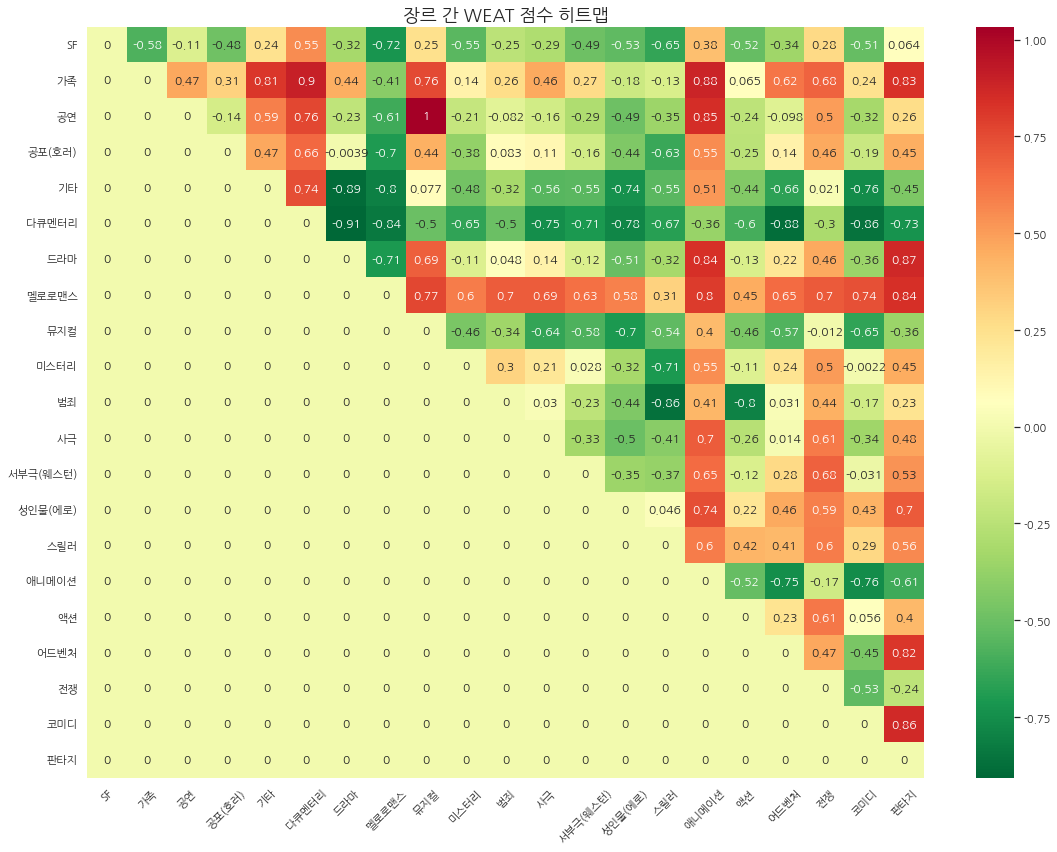

In [151]:
# numpy 랜덤 시드 고정
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 폰트 깨지는 문제 방지
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(16,12))

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')

plt.title("장르 간 WEAT 점수 히트맵", fontsize=18)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

시각화해서 보았을 때도, 성인물 장르가 예술영화와 가깝다고 측정되었고,  
다큐멘터리 장르가 일반(상업)영화와 가깝다고 측정되었다.   

**현재 tf-idf로 선정한 단어 집합은 개념축을 대표하는 대표성을 보여주지 못한다.**

# 회고

단어집합를 생성할 때, word2vec에 있는 단어만 추가하게 되는데,[현재는 synopsis.txt만 학습한 모델이다] word2vec에 모든 데이터를 학습 시킨 후, 차이점을 비교해 보고 싶다.  
중복 단어를 제대로 제거하는 코드로 변경이 필요하다.  
단어 집합의 크기를 늘려서 실험해 보면 어떻게 되는지 궁금하다.  
  
tf-idf 기반으로 편향을 확인한 결과, 사람의 편향과 반대되는 결과를 확인할 수 있었다.  
`문서를 대표하는 단어 집합`을 생각했을때, 빈도수 기반 tf-idf는 적절하지 않은 것 같다.  

LSA, LDA로 문서를 대표하는 단어 집합을 추출하는 방법을 시도해 보고 싶다. 

#### 추가 실험해 볼 수 있는 사항

- 단어 집합의 크기를 늘려본다
- 중복단어를 제대로 제거해본다
- LSA, LDA를 사용해본다.